In [16]:
# 외부 py 파일 수정 시 자동으로 재로드되도록 설정
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# ================================================
# 📦 공통 패키지 import
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import sys

# src 경로 추가
PROJECT_ROOT = os.path.abspath(os.path.join(".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

# seaborn 스타일 설정
sns.set(style="whitegrid")

# ================================================
# ⚙️ 경로 및 상수 설정
# ================================================
DATA_DIR = "../data/processed"
OUTPUT_DIR = "../data/modeling"
SEOUL_STATION_PATH = os.path.join(DATA_DIR, "seoul_env_station_mapped.csv")
OUTPUT_IMG = "../outputs/image"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# KMeans 설정
KMEANS_MODE = "auto" # auto, manual
KMEANS_MANUAL_K = 5

# XGBoost 설정
XGB_N_ESTIMATORS = 100

# MCLP 설정
COVERAGE_RADIUS = 0.005
FACILITY_LIMIT = 30

# ================================================
# 🧪 평가 함수 import
# ================================================
from evaluation.baseline_evaluator import (
    evaluate_existing_stations,
    evaluate_random_installation,
    evaluate_cluster_centers,
    evaluate_mclp_result
)

# MCLP + 시나리오

현재 충전소는 그대로 유지

예상 수요 증가를 반영하여 전체 predicted_demand_score를 scaling

**각 베이스라인 (랜덤, 클러스터, MCLP 등)**은 이 증가된 수요를 기준으로:

추가 충전소를 설치하고

전체 충전소(기존 + 추가)가 얼마나 커버하는지 평가

참고자료1 : https://n.news.naver.com/mnews/article/015/0005137028?sid=100
참고자료2 : https://news.seoul.go.kr/env/archives/558886
참고자료3 : https://www.index.go.kr/unity/potal/main/EachDtlPageDetail.do?idx_cd=1257
- 2024 국내 전기차 운행률 2.6%
- 2030 정부 전기차 보급률 50%
- 2026 서울시 전기차 전환 10%

In [18]:
# 실험 목적 상위 20% 격자 수 추출

# 데이터 로드
future_demand = pd.read_csv("../data/processed/future_demand_gridded_2.csv")

# 상위 20% 수요 격자 추출
demand_k = int(len(future_demand) * 0.20)
top_k = future_demand.nlargest(demand_k, 'final_score').copy()
top_k_ids = set(top_k['grid_id'])

print(f"상위 20% 격자 수 (demand_k): {demand_k}")

상위 20% 격자 수 (demand_k): 47


# K-means

In [19]:
from modeling.kmeans_model import run_kmeans

# 데이터 로드
grid = pd.read_csv(f"{DATA_DIR}/grid_system_processed.csv")

# 수요가 가장 높은 클러스터만 추출
grid , used_k = run_kmeans(
    grid,
    mode=KMEANS_MODE,
    # manual_k=KMEANS_MANUAL_K,
    return_top_cluster_only=True
)

Finding optimal k: 100%|██████████| 9/9 [00:00<00:00, 20.88it/s]

[AUTO MODE] 최적 k = 2
Inertia by k: {2: 394878040.6060905, 3: 182752136.79175264, 4: 111630868.37625772, 5: 83130803.13068569, 6: 65292788.3815513, 7: 54917904.7908943, 8: 48181642.396938056, 9: 36633734.731904596, 10: 32347245.131689377}

[Cluster별 평균 수요]
cluster
1.0    1360.575095
0.0      57.366915
Name: demand_score, dtype: float64

[필터링] 수요가 가장 높은 클러스터 (cluster=1.0)만 반환됨.


KMeans로 수요 밀집 지역을 선별한 후,

해당 지역의 feature만 따로 정리해 저장하는 전처리 단계

→ 이후 모델(XGBoost, MCLP)에서 이 subset만 사용할 수 있게 함.

In [20]:
# 필요한 컬럼만 유지 (grid: KMeans 결과)
grid = grid[['grid_id', 'center_lat', 'center_lon', 'cluster']]

# 원본 feature 로드
features_all = pd.read_csv(f"{DATA_DIR}/grid_features.csv")

# 병합 전: features_all 좌표 제거 (혼동 방지)
features_all = features_all.drop(columns=['center_lat', 'center_lon'], errors='ignore')

# 병합
features = features_all.merge(grid, on='grid_id', how='inner')

# cluster 정수형 처리
features['cluster'] = features['cluster'].astype(int)

# 저장 전 좌표 정리: 이미 이름이 정돈돼 있음
# → center_lat, center_lon 이 grid 기준으로만 존재
features = features.loc[:, ~features.columns.duplicated()]  # 혹시 모를 중복 제거

# 저장
features.to_csv(f"{OUTPUT_DIR}/kmeans_grid_features.csv", index=False)
print("✅ 좌표 컬럼 중복 없이 정리 및 저장 완료")

# 확인
print(f"전체 feature 수: {len(features_all)}")
print(f"수요 밀집 클러스터 feature 수: {len(features)}")
print(f"병합 후 유지된 비율: {len(features) / len(features_all) * 100:.2f}%")
print(f"사용 가능한 feature 컬럼: {features.columns.tolist()}")

✅ 좌표 컬럼 중복 없이 정리 및 저장 완료
전체 feature 수: 6030
수요 밀집 클러스터 feature 수: 526
병합 후 유지된 비율: 8.72%
사용 가능한 feature 컬럼: ['grid_id', 'demand_score', 'supply_score', 'commercial_count', 'station_count', 'supply_demand_ratio', 'population_density', 'accessibility_score', 'transport_score', 'charging_demand_component', 'commercial_demand_component', 'ev_registration_factor', 'time_pattern_factor', 'center_lat', 'center_lon', 'cluster']


In [21]:
# 선택시항

from utils.inspect_dataframe import inspect_dataframe
from visualization.map_visualizer import visualize_cluster_map

# 1. kmeans_grid_features.csv 특징
inspect_dataframe(features, name="features")

# 2. kmeans 시각화 - 서울 전체 (회색) - 수요 (빨간색)
visualize_cluster_map(
    all_features_path=f"{DATA_DIR}/grid_features.csv",
    filtered_features_path=f"{OUTPUT_DIR}/kmeans_grid_features.csv",
    output_path=f"../outputs/maps/kmeans_visualization.html"
)

🧾 입력 데이터 이름: features
🔢 shape: (526, 16)
🔑 컬럼 목록:
['grid_id', 'demand_score', 'supply_score', 'commercial_count', 'station_count', 'supply_demand_ratio', 'population_density', 'accessibility_score', 'transport_score', 'charging_demand_component', 'commercial_demand_component', 'ev_registration_factor', 'time_pattern_factor', 'center_lat', 'center_lon', 'cluster']

🧾 예시 5개:
        grid_id  demand_score  supply_score  commercial_count  station_count  \
0  GRID_011_036         43.22      27.15053               625              0   
1  GRID_011_037         43.22      27.15053               332              0   
2  GRID_012_035         43.22      27.15053               397              0   
3  GRID_012_036         43.22      27.15053               574              1   
4  GRID_014_033         43.22      27.15053               275              1   

   supply_demand_ratio  population_density  accessibility_score  \
0             1.591866                9375                  0.0   
1        

# XGBoost

In [22]:
from modeling.xgboost_model import train_and_predict

# 학습 feature
selected_features = [
    'supply_score',
    'station_count',
    'commercial_count',
    'supply_demand_ratio',
    'population_density',
    'accessibility_score',
    'transport_score',
    'cluster'
]

# 범주형 처리
features['cluster'] = features['cluster'].astype('category')

# XGBoost 학습 및 예측
features_with_pred, metrics, model = train_and_predict(
    df=features,
    features=selected_features,
    label='demand_score',
    n_estimators=XGB_N_ESTIMATORS,
    verbose=True
)

# 저장
features_with_pred.to_csv(f"{OUTPUT_DIR}/xgboost_grid_features.csv", index=False)


XGBoost 성능:
MAE: 0.11
RMSE: 0.18
R²: 0.9997


XGBoost 입력 feature 타입:
grid_id                          object
demand_score                    float64
supply_score                    float64
commercial_count                  int64
station_count                     int64
supply_demand_ratio             float64
population_density                int64
accessibility_score             float64
transport_score                 float64
charging_demand_component       float64
commercial_demand_component     float64
ev_registration_factor          float64
time_pattern_factor             float64
center_lat                      float64
center_lon                      float64
cluster                        category
predicted_demand_score          float64
dtype: object

중요도 시각화 저장 완료: ../outputs/image/xgboost_importance.png


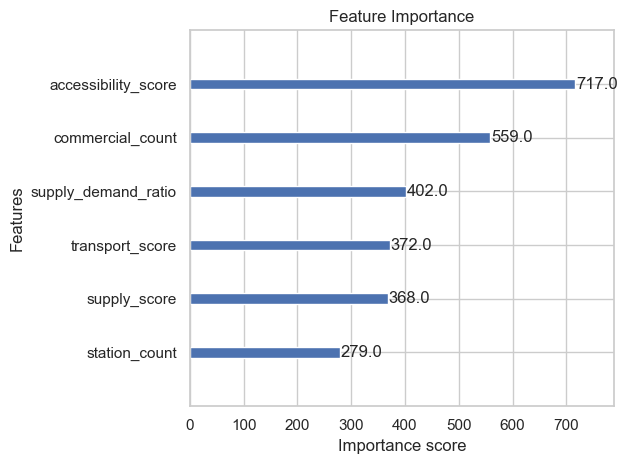

In [23]:
# 선택 사항

# 1. XGBoost 입력 feature 타입
print("XGBoost 입력 feature 타입:")
print(features_with_pred.dtypes)
print("")

from visualization.xgboost_visualizer import plot_feature_importance

# 2. 시각화
plot_feature_importance(model, max_num_features=10, save_path=f"{OUTPUT_IMG}/xgboost_importance.png")

# 3. metrics 저장
pd.DataFrame([metrics]).to_csv(f"{OUTPUT_DIR}/xgboost_metrics.csv", index=False)

# MCLP

In [24]:
from modeling.mclp_model import solve_mclp

# 1. 설정
COVERAGE_RADIUS_KM = 0.55  # 반경 550m
coverage_radius_deg = COVERAGE_RADIUS_KM / 111.0  # degree 환산

# 2. MCLP 실행
final_df, final_summary, _ = solve_mclp(
    df=features_with_pred,                      # XGBoost 예측 포함된 격자 데이터
    coverage_radius=coverage_radius_deg,
    facility_limit=demand_k,                   # 수요 상위 20% 격자 수
    demand_column='predicted_demand_score',
    verbose=True
)


커버리지 행렬 생성:   0%|          | 0/526 [00:00<?, ?it/s]

설치지 수: 47개
커버 수요: 12,734.79 / 총 수요: 28,465.00
커버율: 44.74%


In [25]:
# 3. 결과 저장
final_df.to_csv(f"{OUTPUT_DIR}/mclp_grid_features.csv", index=False)                 # 전체 결과
final_df[final_df['selected'] == 1].to_csv(f"{OUTPUT_DIR}/mclp_selected_grid_features.csv", index=False)  # 선택된 설치 위치만 저장

In [26]:
# 선택사항 - mclp 후 지역 시각화

from visualization.map_visualizer import visualize_selected_sites_map

visualize_selected_sites_map(
    features_path=f"{OUTPUT_DIR}/mclp_grid_features.csv",
    output_path=f"../outputs/maps/mclp_result_map.html"
)

설치지 시각화 저장 완료: ../outputs/maps/mclp_result_map.html


# 평가

## 설치 방식 비교 실험

### 1. 실험 목적
전기차 충전소 입지 선정 방식에 따라 **미래 수요 상위 지역을 얼마나 잘 커버하는지**를 비교한다.  
수요 기반 알고리즘(MCLP, 클러스터링 등)이 **기존 설치 방식이나 무작위 설치 대비 얼마나 효율적인지** 확인하는 것이 목적이다.

---

### 2. 실험 방식

- **수요 기준**: `future_demand_gridded.csv`의 adjusted_ev_demand 컬럼 기준
- **상위 격자 수**: 전체 격자 중 상위 20%인 `demand_k = 47`개
- **설치 방식별 선정 방식**:
  - **기존 충전소 전체**: 서울시의 모든 기존 충전소 설치 격자
  - **랜덤 설치**: 기존 충전소 중 무작위 47개 선택
  - **클러스터 기반 설치**: KMeans 클러스터 격자 중 `demand_score` 상위 47개
  - **MCLP 추천 설치**: KMeans → XGBoost → MCLP 로 구성된 복합 전략

---

### 3. 평가 지표

- **포함된 격자 수**: 상위 47개 수요 격자 중 설치된 격자의 수
- **커버 수요**: 해당 격자들이 커버한 수요 총합
- **커버율 (%)**: `(커버 수요 / 전체 상위 수요) * 100`
- **설치 효율**: `커버 수요 / 설치 격자 수`

---

### 4. 실험 결과

| 설치 방식             | 포함 격자 수 | 커버 수요     | 전체 수요     | 커버율 (%) | 설치 효율 |
|----------------------|--------------|---------------|---------------|-------------|------------|
| 기존 충전소 전체      | 33 / 47      | 275,653.50    | 324,565.50    | 84.93       | 157.25     |
| 랜덤 설치            | 0 / 47       | 0.00          | 324,565.50    | 0.00        | 0.00       |
| 클러스터 기반 설치   | 1 / 47       | 6,103.50      | 324,565.50    | 1.88        | 129.86     |
| MCLP 추천 설치       | 4 / 47       | 34,884.00     | 324,565.50    | 10.75       | 742.21     |

---

### 5. 분석 요약

- **기존 충전소 전체**는 높은 커버율을 보이지만 설치 효율은 낮다.
- **랜덤 설치**는 커버 수요가 전무하여 가장 비효율적이다.
- **클러스터 기반 설치**는 예측 수요는 높았지만, 상위 수요 지역과 겹침이 적어 실효성이 낮다.
- **MCLP 추천 설치**는 상대적으로 적은 수의 설치만으로도 높은 효율을 보이며, 전략적 입지 선정의 효과를 입증하였다.

In [27]:
import pandas as pd

# 1. 데이터 로드
stations = pd.read_csv("../data/processed/charging_stations_seoul_gridded.csv")
future_demand = pd.read_csv("../data/processed/future_demand_gridded_2.csv")
grid_features = pd.read_csv("../data/processed/grid_features.csv")                 
kmeans_features = pd.read_csv("../data/modeling/kmeans_grid_features.csv")         # 클러스터 기반
mclp_features = pd.read_csv("../data/modeling/mclp_selected_grid_features.csv")    # MCLP 결과

# 2. 전체 격자 중 adjusted_ev_demand 기준 상위 20% 추출
demand_k = int(len(future_demand) * 0.20)
top_k = future_demand.nlargest(demand_k, 'adjusted_ev_demand').copy()
top_k_ids = set(top_k['grid_id'])

print(f"상위 20% 격자 수 (demand_k): {demand_k}")

# 3. 설치 방식별 격자 선택

# 3-1. 기존 충전소 전체
existing_grids = set(stations['grid_id'])

# 3-2. 랜덤 설치: 기존 충전소가 설치된 격자 중 demand_k개 무작위 선택
random_grids = set(stations.sample(n=demand_k, random_state=42)['grid_id'])

# 3-3. 클러스터 기반 설치: KMeans 클러스터 내 격자들 중 demand_score 기준 상위 demand_k개
cluster_sorted = kmeans_features.sort_values('demand_score', ascending=False)
cluster_grids = set(cluster_sorted['grid_id'].dropna().head(demand_k))

# 3-4. MCLP 추천 설치: selected == 1로 표시된 격자 모두 사용
mclp_grids = set(mclp_features[mclp_features['selected'] == 1]['grid_id'])

# 4. 평가 함수
def evaluate_grid_overlap(top_k_df, selected_grids, label):
    matched = top_k_ids & selected_grids
    matched_count = len(matched)
    matched_demand = top_k_df[top_k_df['grid_id'].isin(matched)]['adjusted_ev_demand'].sum()
    total_demand = top_k_df['adjusted_ev_demand'].sum()
    coverage_rate = matched_demand / total_demand * 100
    efficiency = matched_demand / len(selected_grids) if selected_grids else 0

    print(f"\n[{label}]")
    print(f"- 포함된 격자 수: {matched_count} / 상위 {len(top_k_df)}개")
    print(f"- 커버 수요: {matched_demand:,.2f}")
    print(f"- 전체 수요: {total_demand:,.2f}")
    print(f"- 커버율: {coverage_rate:.2f}%")
    print(f"- 설치 1개당 커버 수요 (효율): {efficiency:,.2f}")

# 5. 평가 실행
evaluate_grid_overlap(top_k, existing_grids, "기존 충전소 전체")
evaluate_grid_overlap(top_k, random_grids, "랜덤 설치")
evaluate_grid_overlap(top_k, cluster_grids, "클러스터 기반 설치")
evaluate_grid_overlap(top_k, mclp_grids, "MCLP 추천 설치")

상위 20% 격자 수 (demand_k): 47

[기존 충전소 전체]
- 포함된 격자 수: 33 / 상위 47개
- 커버 수요: 275,653.50
- 전체 수요: 324,565.50
- 커버율: 84.93%
- 설치 1개당 커버 수요 (효율): 157.25

[랜덤 설치]
- 포함된 격자 수: 0 / 상위 47개
- 커버 수요: 0.00
- 전체 수요: 324,565.50
- 커버율: 0.00%
- 설치 1개당 커버 수요 (효율): 0.00

[클러스터 기반 설치]
- 포함된 격자 수: 1 / 상위 47개
- 커버 수요: 6,716.00
- 전체 수요: 324,565.50
- 커버율: 2.07%
- 설치 1개당 커버 수요 (효율): 142.89

[MCLP 추천 설치]
- 포함된 격자 수: 1 / 상위 47개
- 커버 수요: 10,485.00
- 전체 수요: 324,565.50
- 커버율: 3.23%
- 설치 1개당 커버 수요 (효율): 223.09


# XX (기타)

In [28]:
import pandas as pd

# 파일 경로 지정
paths = {
    "future_demand": "../data/processed/future_demand_gridded_2.csv",
    "grid_features": "../data/processed/grid_features.csv",
    "kmeans_features": "../data/modeling/kmeans_grid_features.csv",
    "mclp_features": "../data/modeling/mclp_selected_grid_features.csv",
    "charging_stations": "../data/processed/charging_stations_seoul_gridded.csv"
}

# 결과 출력
for name, path in paths.items():
    df = pd.read_csv(path)
    n = df['grid_id'].nunique()
    print(f"{name} → grid_id 개수: {n}")

future_demand → grid_id 개수: 122
grid_features → grid_id 개수: 6030
kmeans_features → grid_id 개수: 526
mclp_features → grid_id 개수: 47
charging_stations → grid_id 개수: 1753


In [33]:
import pandas as pd

# 데이터 불러오기
future = pd.read_csv("../data/processed/future_demand_gridded_2.csv")
grid = pd.read_csv("../data/processed/grid_features.csv")  # center_lat, center_lon 포함

# 병합 (좌표 추가)
merged = future.merge(grid[['grid_id', 'center_lat', 'center_lon']], on='grid_id', how='left')

# 확인
print(merged.head())

# 저장 (선택)
merged.to_csv("../data/processed/future_demand_gridded_2_with_coords.csv", index=False)

        grid_id  demand_score  adjusted_ev_demand  log_future  norm_current  \
0  GRID_003_051         22.05              2745.5    7.918083           0.0   
1  GRID_003_051         22.05              3783.5    8.238669           0.0   
2  GRID_011_020         22.05              3621.5    8.194920           0.0   
3  GRID_011_020         22.05              2230.0    7.710205           0.0   
4  GRID_012_020         22.05              2745.5    7.918083           0.0   

   norm_log_future  final_score  center_lat  center_lon  
0         0.827839     0.331136    37.41575    126.9884  
1         0.861357     0.344543    37.41575    126.9884  
2         0.856783     0.342713    37.45175    126.8148  
3         0.806106     0.322442    37.45175    126.8148  
4         0.827839     0.331136    37.45625    126.8148  


In [35]:
import pandas as pd
import folium

# 1. 파일 경로 및 컬럼 정보 정의
datasets = {
    "future_demand": {
        "path": "../data/processed/future_demand_gridded_2_with_coords.csv",
        "lat": "center_lat",
        "lon": "center_lon",
        "color": "green"
    },
    "grid_features": {
        "path": "../data/processed/grid_features.csv",
        "lat": "center_lat",
        "lon": "center_lon",
        "color": "gray"
    },
    "kmeans_features": {
        "path": "../data/modeling/kmeans_grid_features.csv",
        "lat": "center_lat",
        "lon": "center_lon",
        "color": "blue"
    },
    "mclp_features": {
        "path": "../data/modeling/mclp_selected_grid_features.csv",
        "lat": "center_lat",
        "lon": "center_lon",
        "color": "red"
    },
    "charging_stations": {
        "path": "../data/processed/charging_stations_seoul_gridded.csv",
        "lat": "위도",
        "lon": "경도",
        "color": "purple"
    }
}

# 2. 지도 초기화
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 3. 각 데이터셋을 지도에 추가
for name, info in datasets.items():
    df = pd.read_csv(info["path"])
    lat_col = info["lat"]
    lon_col = info["lon"]
    color = info["color"]

    layer = folium.FeatureGroup(name=name, show=True)

    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=0.5,
            popup=f"{name}: {row.get('grid_id', 'N/A')}"
        ).add_to(layer)

    layer.add_to(m)

# 4. 레이어 컨트롤 추가 및 저장
folium.LayerControl().add_to(m)
m.save("../outputs/maps/all_grids_combined_map.html")
print("✅ 지도 저장 완료: ../outputs/maps/all_grids_combined_map.html")

✅ 지도 저장 완료: ../outputs/maps/all_grids_combined_map.html
